# Deep Reinforcement Learning with Continuous Control - DDPG, TD3 and A2C applied to Reacher

---
This project is a part of the Udacity Deep Reinforcement Learning Nano-degree requirement. In this report, I described how I used three Deep Reinforcement Learning algorithms - [DDPG](https://arxiv.org/abs/1509.02971), [TD3](https://arxiv.org/pdf/1802.09477.pdf) and [A2C](https://arxiv.org/abs/1602.01783v2) to solve the Reacher game  provided by Unity Environment [here](https://github.com/Unity-Technologies/ml-agents/tree/release_12_docs). All three algorithms are applied to solve the problem with a control/action space.

Please note that in comparing the performance of the three algorithms, there is very limited tuning of the hyperparameters.


### The Environment

<img src='reacher.gif'>

The game environment is provided by Unit Technology (please refer to README on how to install). The agents are two-jointed robot arms learning to track a moving object as many time steps as possible. A reward of `+0.1` is earned each step the agent track closely to the moving object. The environment is considered solved when the return reaches an average of `30` consistently (over 100 episodes). 

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


In [2]:
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

In [3]:
# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`. There is only `1` agent in this environment but in the A2C section I will use another version of the same environment with `20` agents.

In [4]:
brain_name = env.brain_names[0]
brain=env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33


### DDPG

[DDPG](https://arxiv.org/abs/1509.02971) was introduced to deal with problems with continuous controls, which is the case for this project. I will use it as the baseline. Please note I have only performed very limit hyper-parameter tuning, so the comparison is definitely not conclusive.

The hyper-parameters are set as following:  
1. A 3-layer neural network with an input dimension of 33 for the actor and 37 (33+4) for the value/critic, first hidden layer dimension of 400, second hidden layer of 300 and output layer dimension of 4 for the actor and 1 for the value/critic. ReLU activation function is applied for all layers except the output layer, where a Tanh function is applied to the actor and no activation function for the value/critic.
2. The discount factor is set to 0.995. 
3. The memory is set to 10,000 entries. 
4. The optimizer is set to Adam optimizer with a learning rate of 0.00005 
5. TAU, the rate at which the target network is synchronized to the policy network every time step is set to 0.005. 
6. The policy noise is set to 0.1; the action adding the noise is clipped to be between -0.5 and 0.5 
7. Finally, DDPG is run 500 episodes with a batch size of 50.

Episode 49	Average Score: 1.76
Episode 99	Average Score: 3.61
Episode 149	Average Score: 6.41
Episode 199	Average Score: 7.90
Episode 249	Average Score: 9.65
Episode 299	Average Score: 14.39
Episode 349	Average Score: 21.81
Episode 399	Average Score: 27.77
Episode 449	Average Score: 29.32
Episode 499	Average Score: 26.95


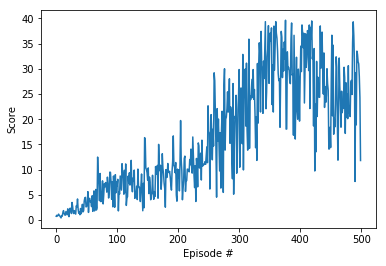

In [5]:
from Agent_DDPG import DDPGAgent
agent_ddpg = DDPGAgent(state_size, action_size)

def ddpg(agent, n_episodes=500, max_t=1000, update_every=1, batch_size=50, policy_noise=0.1):
    step = 0
    scores_ddpg = []
    scores_window = deque(maxlen=100)

    for i in range(n_episodes):
        score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations

        for t in range(max_t):
            action = agent.act(state, policy_noise)
            env_info = env.step(action)[brain_name]
            state_next = env_info.vector_observations
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.cache(state, action, reward, state_next, done)
            step += 1
            if (len(agent.memory) >= batch_size) and (step % update_every) == 0:
                experiences = agent.recall(batch_size)
                agent.learn(experiences)
                agent.sync_target()
            state = state_next
            score += reward
            if done:
                break

        scores_window.append(score)
        scores_ddpg.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
        if (i+1) % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))

    torch.save(agent.actor.state_dict(),'checkpoint_actor_ddpg.pth')
    return scores_ddpg

scores_ddpg = ddpg(agent_ddpg)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ddpg)), scores_ddpg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

DDPG briefly reaches an average return of 30 and deteriorates afterwards. Experimenting with different learning rate proves to improve the performance but DDPG does suffers from stability issue as shown.

### TD3

[TD3](https://arxiv.org/pdf/1802.09477.pdf) improves from DDPG by replacing the one set of target networks  with two separate sets and with delayed learning to stablize the learning.

All hyper-parameters are the same as the previous DDPG setup, except the following:
1. The network is updated every 3 time steps and,
2. There are two separate sets of targets for both the actor and value/critic with the same neural network structure.

Episode 49	Average Score: 1.62
Episode 99	Average Score: 3.31
Episode 149	Average Score: 7.69
Episode 199	Average Score: 11.42
Episode 249	Average Score: 14.66
Episode 299	Average Score: 18.67
Episode 349	Average Score: 23.56
Episode 399	Average Score: 28.80
Episode 449	Average Score: 33.04
Episode 499	Average Score: 35.06


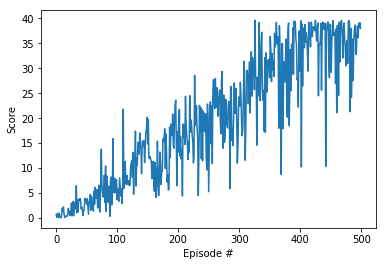

In [6]:
from Agent_TD3 import TD3Agent 

agent_TD3 = TD3Agent(state_size, action_size)

def TD3(agent, n_episodes=500, max_t=1000, update_every=3, batch_size=50, policy_noise=0.1):
    step = 0
    scores_td3 = []
    scores_window = deque(maxlen=100)

    for i in range(n_episodes):
        score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations

        for t in range(max_t):
            action = agent.act(state, policy_noise)
            env_info = env.step(action)[brain_name]
            state_next = env_info.vector_observations
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.cache(state, action, reward, state_next, done)
            step += 1
            if (len(agent.memory) >= batch_size) and (step % update_every) == 0:
                experiences = agent.recall(batch_size)
                agent.learn(experiences)
                agent.sync_target()
            state = state_next
            score += reward
            if done:
                break

        scores_window.append(score)
        scores_td3.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
        if (i+1) % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))

    torch.save(agent.actor.state_dict(), 'checkpoint_actor_td3.pth')
    return scores_td3

scores_td3 = TD3(agent_TD3)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_td3)), scores_td3)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

TD3 reaches an average return of 30+ after 300 episodes and it seems to be more stable than DDPG.

In [ ]:
env.close()

### A2C

Both DDPG and TD3 are off-policy learning, which is data efficent but can have stability issue. They also both train a single agent at a time. [A2C](https://arxiv.org/abs/1602.01783v2) is on-policy learning  and is supposed to be more stable; it also trains multiple agents simultaneously.

The hyper-parameters are set as following:  
1. The same 3-layer neural network for the actor and critic as the previous DDPG and TD3 setup except a Guassian process is added to the previous actor to derive the policy function. A new parameter is the standard deviation of the Guassian process.
2. The combined loss function consists the policy loss, value function loss and a consideration of the entropy of the policy function, which is set to 0. 
3. The optimizer is set to Adam optimizer with a learning rate of 0.00001 
4. The rollout or n step learning period is set to 4. 
All the other parameters are same as the prevoius DDPG and TD3. Obviously, there is no need for memory or batch. 

In [3]:
# select this option to load version 2 (with 20 agents) of the environment 
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain=env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


Episode 49	Average Score: 3.15
Episode 99	Average Score: 10.37
Episode 149	Average Score: 26.83
Episode 199	Average Score: 36.97
Episode 249	Average Score: 37.89
Episode 299	Average Score: 38.21


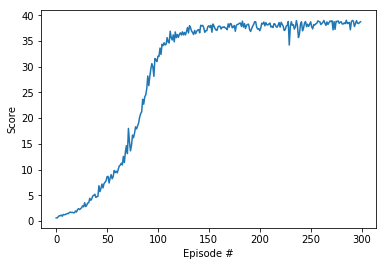

In [5]:
from Agent_A2C import A2CAgent

# rollout length for TD(n)
n_step = 4
agent = A2CAgent(state_size, action_size, n_step)

def A2C(agent, n_episodes=300, max_t=1000, gamma = 0.995):
    scores_A2C = []
    scores_window = deque(maxlen=100)

    for i in range(n_episodes):
        score = 0.
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset_cache()

        for t in range(max_t):
            preds = agent.step(states)
            actions = preds['actions']
            env_info = env.step(actions.cpu().data.numpy())[brain_name]
            rewards = np.array(env_info.rewards)
            dones = np.array(env_info.local_done).astype(float)
            states_next = env_info.vector_observations
            agent.cache(states, actions, rewards, dones, preds['log_probs'], preds['entropy'], preds['Vs'])

            if len(agent.memory) > n_step:
                Gs = preds['Vs'].cpu().data.numpy()
                for j in reversed(range(n_step)):
                    Gs = agent.memory[j].rewards.cpu().data.numpy() * \
                         (1 - agent.memory[j].dones.cpu().data.numpy()) + Gs * gamma

                Ads = Gs - agent.memory[0].Vs.cpu().data.numpy()
                agent.learn(Gs, Ads)

            states = states_next
            score += np.array(rewards).mean()

        scores_window.append(score)
        scores_A2C.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
        if (i+1) % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))

    torch.save(agent.network.state_dict(), 'checkpoint_A2C.pth')
    return scores_A2C

scores_A2C = A2C(agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_A2C)), scores_A2C)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

As expected, A2C learning is a lot more stable. The performance is also considerably better, reaching an average return of 30+ before 200 episodes.

### Conclusions

All three algorithms - DDPG, TD3 and A2C can successfully solve the problem. But it seems A2C is better in terms of performance and stability, compared to off-policy algorithm DDPG and TD3. TD3 seems to be better than DDPG.

There are a number of potential future improvements:  
1. A more systematic hyperparameter tuning
2. Try Proximal Policy Optimization, Trust Region Policy Optimization (TRPO) and Truncated Natural Policy Gradient (TNPG) 
3. For the multi-agent setting, adding Generalized Advantage Estimation as an option in addition to N-step return for A2C
4. For the multi-agent setting, consider other asynchronous method such as Distributional Deterministic Policy Gradient [here](https://openreview.net/pdf?id=SyZipzbCb)

In [6]:
env.close()